In [10]:
!pip install colorthief


In [11]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
import sys
import os
from __future__ import division
plt.rcParams["figure.figsize"] = (20,10)
from itertools import chain
import tqdm as tqdm
from colorthief import ColorThief

warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [70]:
votes_data = pd.read_excel('ESC2018_GF.xlsx',sheet_name='Combined result')
print(votes_data.shape)
votes_data.head(5)

(26, 47)


,Rank,Running order,Country,Total,Albania,Austria,Belarus,Belgium,Croatia,Cyprus,Denmark,Estonia,Macedonia,Finland,France,Germany,Greece,Iceland,Ireland,Israel,Latvia,Lithuania,Malta,Netherlands,Norway,Poland,Portugal,Romania,Russia,Serbia,Slovenia,Spain,Sweden,Switzerland,Ukraine,United Kingdom,Bulgaria,Hungary,Moldova,Armenia,Czech Republic,Georgia,Montenegro,Azerbaijan,San Marino,Italy,Australia
0,1,22,Israel,529,6,19,8,16,16,10,3,0,4,19,24,11,10,15,13,0,8,7,14,15,7,10,2,8,18,9,1,22,17,6,22,17,14,16,22,18,22,15,1,13,24,9,18
1,2,25,Cyprus,436,20,1,15,11,8,0,6,12,18,7,3,9,24,3,17,2,1,7,22,11,7,8,5,12,11,10,14,20,16,10,4,8,15,7,13,19,8,10,6,14,7,8,7
2,3,5,Austria,342,2,0,10,15,0,2,18,18,0,10,7,15,0,17,5,13,7,15,1,13,16,12,8,12,0,4,12,8,12,8,7,12,16,11,3,7,5,9,0,0,0,7,5
3,4,11,Germany,340,14,16,0,7,3,3,24,6,3,1,8,0,2,14,16,8,3,7,4,24,18,11,8,8,4,10,4,13,6,18,0,3,6,1,8,5,3,7,0,5,14,13,12
4,5,26,Italy,308,24,10,4,6,10,15,0,7,6,10,10,12,9,0,0,5,6,7,22,7,0,5,14,6,7,14,10,10,0,8,5,0,6,6,8,3,2,5,12,5,12,0,0


In [71]:
votes_data.tail(5)


,Rank,Running order,Country,Total,Albania,Austria,Belarus,Belgium,Croatia,Cyprus,Denmark,Estonia,Macedonia,Finland,France,Germany,Greece,Iceland,Ireland,Israel,Latvia,Lithuania,Malta,Netherlands,Norway,Poland,Portugal,Romania,Russia,Serbia,Slovenia,Spain,Sweden,Switzerland,Ukraine,United Kingdom,Bulgaria,Hungary,Moldova,Armenia,Czech Republic,Georgia,Montenegro,Azerbaijan,San Marino,Italy,Australia
21,22,3,Slovenia,64,0,5,4,0,7,0,0,0,4,0,2,0,0,0,0,4,1,0,0,1,0,0,3,1,0,8,0,0,0,0,5,0,0,0,0,0,7,0,6,0,6,0,0
22,23,2,Spain,61,0,0,0,1,0,7,6,0,0,0,5,6,0,0,1,0,0,0,0,0,2,0,14,10,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,7
23,24,9,United Kingdom,48,3,0,0,0,2,0,3,0,0,0,3,1,0,0,10,8,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,6,6
24,25,17,Finland,46,0,0,0,0,0,0,0,12,5,0,0,0,0,3,0,6,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,4,0,0,0,0,3,0,0,0,0,0,4
25,26,8,Portugal,39,0,0,0,0,0,0,0,3,0,0,8,0,0,0,6,0,0,7,0,2,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0


In [72]:
votes_melted = votes_data.melt(
    ['Rank','Running order','Country','Total'],
    var_name = 'Source Country',value_name='points')

In [73]:
votes_melted.head()


,Rank,Running order,Country,Total,Source Country,points
0,1,22,Israel,529,Albania,6
1,2,25,Cyprus,436,Albania,20
2,3,5,Austria,342,Albania,2
3,4,11,Germany,340,Albania,14
4,5,26,Italy,308,Albania,24


In [74]:
G = nx.from_pandas_edgelist(votes_melted, 
                            source='Source Country',
                            target='Country',
                            edge_attr='points',
                            create_using=nx.DiGraph())

In [75]:
print(nx.info(G))

DiGraph with 43 nodes and 1118 edges


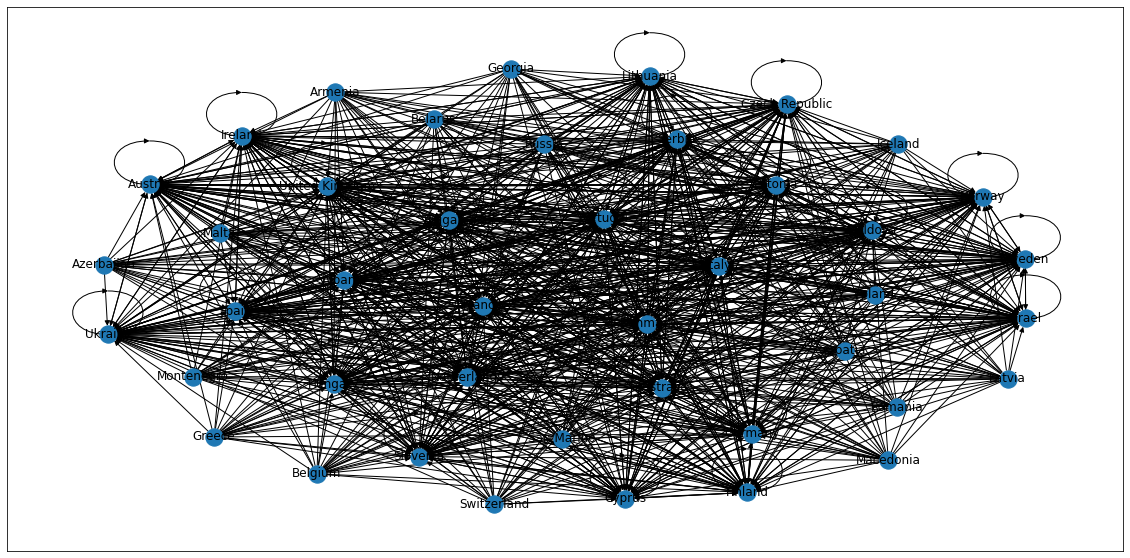

In [76]:
nx.draw_networkx(G)


In [77]:
G.out_degree(weight='points')


OutDegreeView({'Albania': 116, 'Israel': 116, 'Cyprus': 116, 'Austria': 116, 'Germany': 116, 'Italy': 116, 'Czech Republic': 116, 'Sweden': 116, 'Estonia': 116, 'Denmark': 116, 'Moldova': 116, 'Lithuania': 116, 'France': 116, 'Bulgaria': 116, 'Norway': 116, 'Ireland': 116, 'Ukraine': 116, 'Netherlands': 116, 'Serbia': 116, 'Australia': 116, 'Hungary': 116, 'Slovenia': 116, 'Spain': 116, 'United Kingdom': 116, 'Finland': 116, 'Portugal': 116, 'Belarus': 116, 'Belgium': 116, 'Croatia': 116, 'Macedonia': 116, 'Greece': 116, 'Iceland': 116, 'Latvia': 116, 'Malta': 116, 'Poland': 116, 'Romania': 116, 'Russia': 116, 'Switzerland': 116, 'Armenia': 116, 'Georgia': 116, 'Montenegro': 116, 'Azerbaijan': 116, 'San Marino': 116})

In [78]:
Gsub = G.edge_subgraph([(e[0],e[1]) for e in G.edges(data=True) if e[2]['points']>0])


In [80]:

print (nx.info(Gsub))


DiGraph with 43 nodes and 650 edges


(array([16.,  1.,  3.,  2.,  3.,  5.,  4.,  1.,  4.,  4.]),
 array([13. , 17.5, 22. , 26.5, 31. , 35.5, 40. , 44.5, 49. , 53.5, 58. ]),
 <a list of 10 Patch objects>)

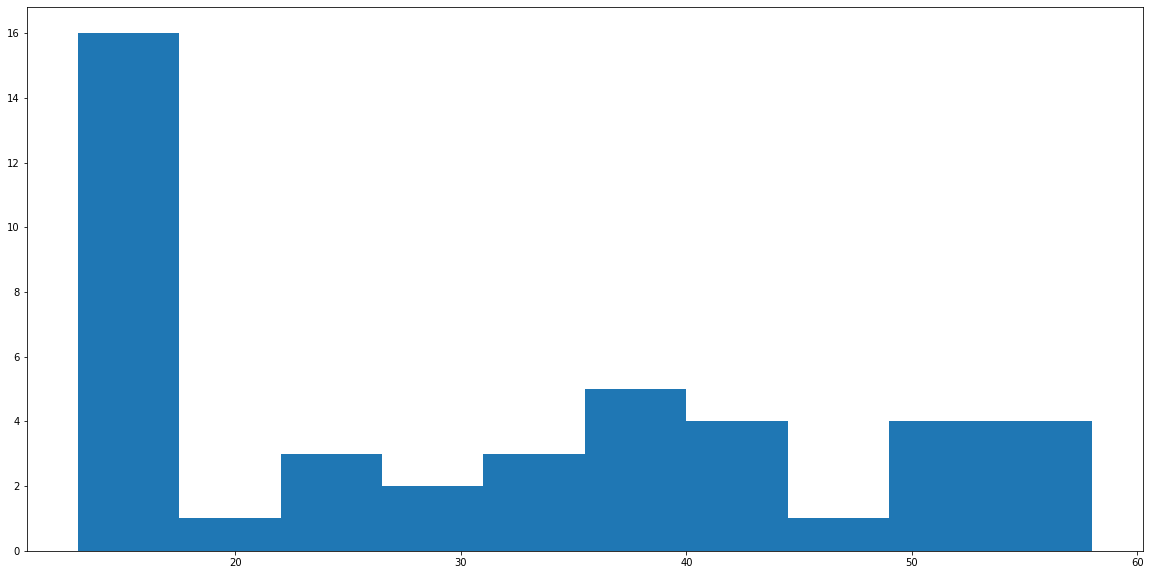

In [81]:
plt.hist(dict(Gsub.degree()).values())


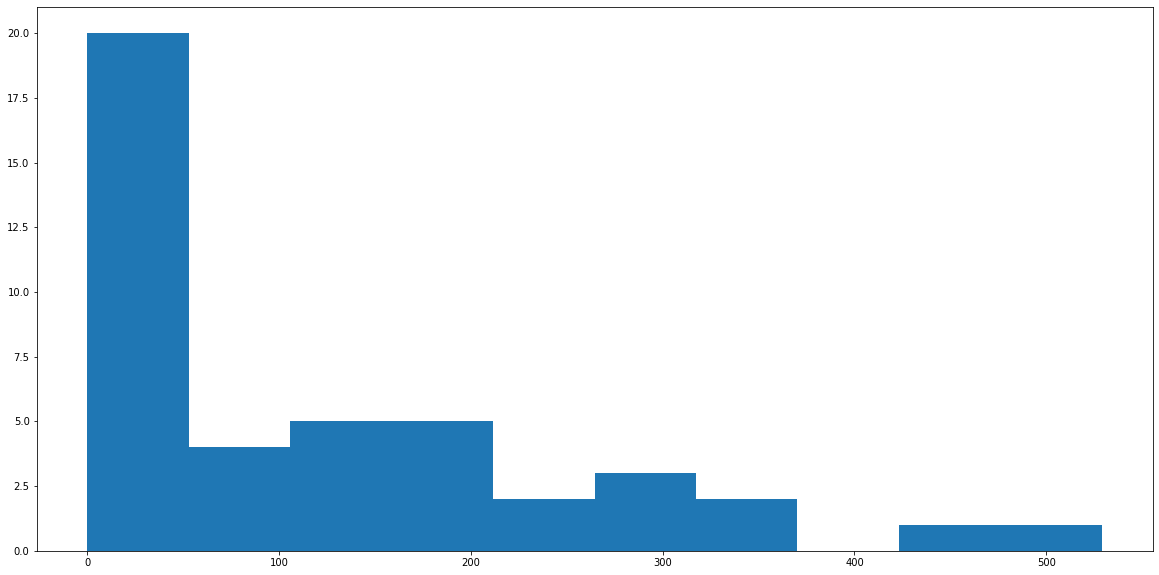

In [82]:
h = plt.hist(dict(G.in_degree(weight='points')).values())


In [83]:
deg_cen_points = dict(G.in_degree(weight='points'))
{k:deg_cen_points[k] for k in deg_cen_points if deg_cen_points[k]==max(deg_cen_points.values())}

{'Israel': 529}

In [84]:
page_rank = dict(nx.pagerank_numpy(G,weight='points'))
{k:page_rank[k] for k in page_rank if page_rank[k]==max(page_rank.values())}

{'Israel': 0.09068710831987278}

In [85]:
between = dict(nx.betweenness_centrality(G,weight='points'))
{k:between[k] for k in between if between[k]==max(between.values())}

{'Estonia': 46701.144689294066}

In [86]:
countries = pd.read_csv('countries.csv',index_col='Country')


In [87]:
countries.head()

,cc2,cc3,numeric,latitude,longitude
Country,,,,,
Afghanistan,AF,AFG,4,33.0000,65.0
Albania,AL,ALB,8,41.0000,20.0
Algeria,DZ,DZA,12,28.0000,3.0
American Samoa,AS,ASM,16,-14.3333,-170.0
Andorra,AD,AND,20,42.5000,1.6


In [88]:
pos_geo = {  node: 
           ( max(-10,min(countries.loc[node]['longitude'],55)), # fixing scale
             max(countries.loc[node]['latitude'],25)) #fixing scale
               for node in G.nodes() }

In [89]:
pos_geo = {}
for node in G.nodes():
    pos_geo[node] = (
                    max(-10,min(countries.loc[node]['longitude'],55)), # fixing scale
                    max(countries.loc[node]['latitude'],25) #fixing scale
    )

In [91]:
flags = {}
flag_color = {}
for node in tqdm.tqdm_notebook(G.nodes()):
    flags[node] = 'flags/'+(countries.loc[node]['cc3']).lower().replace(' ','')+'.png'   
    flag_color[node] =  ColorThief(flags[node]).get_color(quality=1)

  0%|          | 0/43 [00:00<?, ?it/s]

In [92]:
def RGB(red,green,blue): 
    return '#%02x%02x%02x' % (red,green,blue)

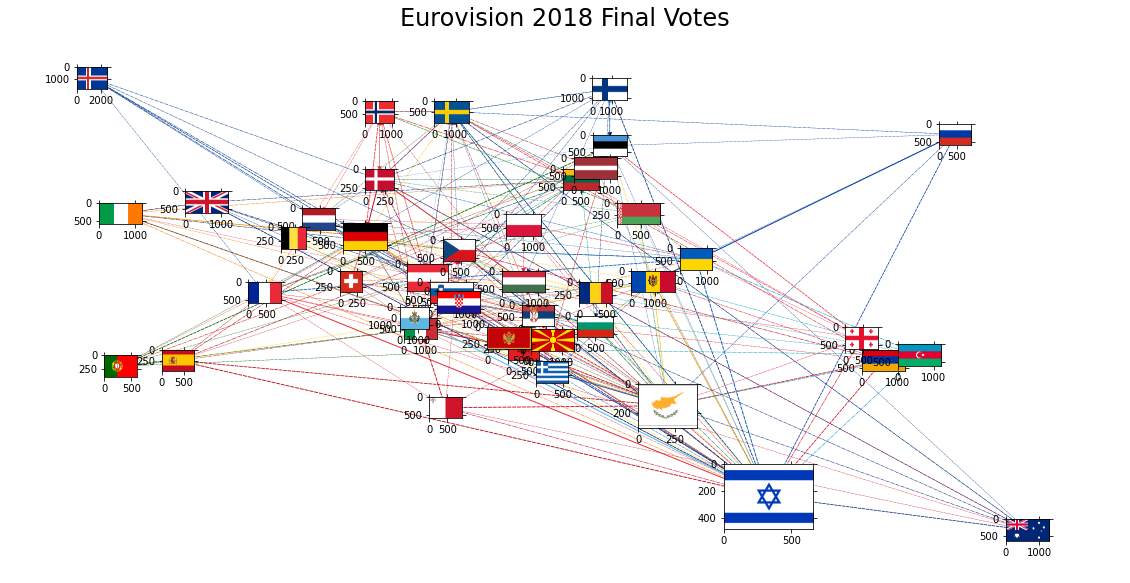

In [94]:
ax=plt.gca()
fig=plt.gcf()
plt.axis('off')
plt.title('Eurovision 2018 Final Votes',fontsize = 24)

trans = ax.transData.transform
trans2 = fig.transFigure.inverted().transform

tick_params = {'top':'off', 'bottom':'off', 'left':'off', 'right':'off',
              'labelleft':'off', 'labelbottom':'off'} #flag grid params

styles = ['dotted','dashdot','dashed','solid'] # line styles

pos = pos_geo
    
# draw edges
for e in G.edges(data=True):
    width = e[2]['points']/24 #normalize by max points
    style=styles[int(width*3)]
    if width>0.3: #filter small votes
        nx.draw_networkx_edges(G,pos,edgelist=[e],width=width, style=style, edge_color = RGB(*flag_color[e[0]]) )
        # in networkx versions >2.1 arrowheads can be adjusted

#draw nodes    
for node in G.nodes():      
    imsize = max((0.3*G.in_degree(node,weight='points')
                  /max(dict(G.in_degree(weight='points')).values()))**2,0.03)
    
    # size is proportional to the votes
    flag = mpl.image.imread(flags[node])
    
    (x,y) = pos[node]
    xx,yy = trans((x,y)) # figure coordinates
    xa,ya = trans2((xx,yy)) # axes coordinates
    
    country = plt.axes([xa-imsize/2.0,ya-imsize/2.0, imsize, imsize ])
    country.imshow(flag)
    country.set_aspect('equal')
    country.tick_params(**tick_params)
    
fig.savefig('images/eurovision2018_map.png')

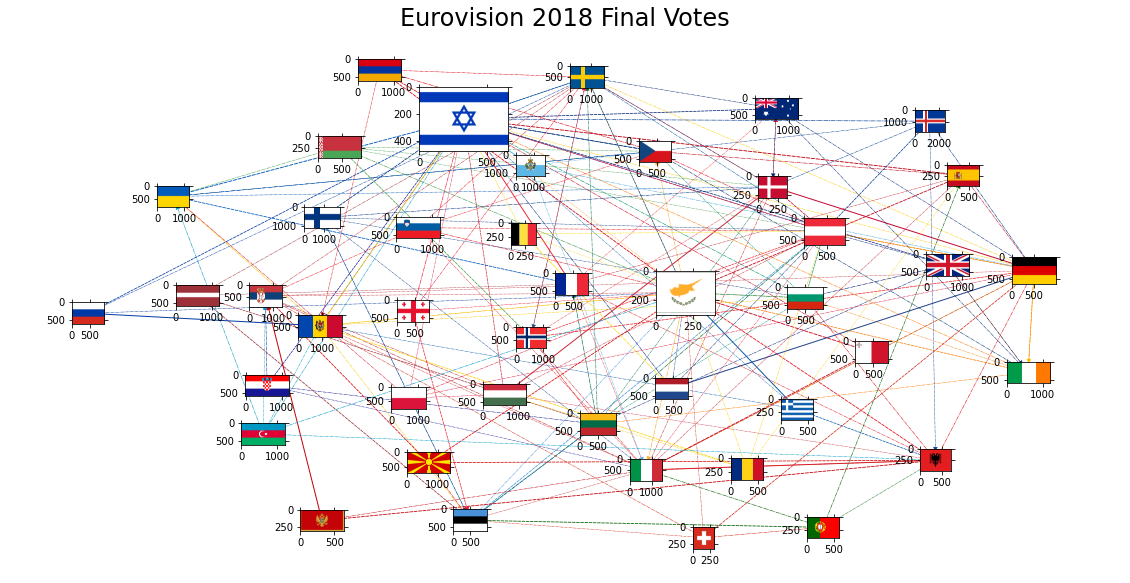

In [95]:
ax=plt.gca()
fig=plt.gcf()
plt.axis('off')
plt.title('Eurovision 2018 Final Votes',fontsize = 24)

pos = nx.layout.fruchterman_reingold_layout(G,k=1,weight = 'points',iterations=1000,scale = 2)

trans = ax.transData.transform
trans2 = fig.transFigure.inverted().transform


tick_params = {'top':'off', 'bottom':'off', 'left':'off', 'right':'off',
              'labelleft':'off', 'labelbottom':'off'} #flag grid params
styles = ['dotted','dashdot','dashed','solid'] # line styles



# draw edges
for e in G.edges(data=True):
    width = e[2]['points']/24 #normalize by max points
    style=styles[int(width*3)]
    if width>0.4: #filter small votes
        nx.draw_networkx_edges(G,pos,edgelist=[e],width=width, 
                               style=style, edge_color = RGB(*flag_color[e[0]]) )
        # in networkx versions >2.1 arrowheads can be adjusted

#draw nodes    
for node in G.nodes():    
    imsize = max((0.3*G.in_degree(node,weight='points')/max(dict(G.in_degree(weight='points')).values()))**2,0.03)
    # size is proportional to the votes
    flag = mpl.image.imread(flags[node])
    
    (x,y) = pos[node]
    xx,yy = trans((x,y)) # figure coordinates
    xa,ya = trans2((xx,yy)) # axes coordinates
    
    country = plt.axes([xa-imsize/2.0,ya-imsize/2.0, imsize, imsize ])
    country.imshow(flag)
    country.set_aspect('equal')
    country.tick_params(**tick_params)
    
fig.savefig('images/eurovision2018_spring.png')
